<a href="https://colab.research.google.com/github/Haadi-kp/Image_Colourization/blob/main/Colab_Notebooks/Copy_of_new_structure_04_01_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create the destination folder if it doesn't exist
!mkdir -p /content/datas



In [ ]:


# Unzip files into the 'datas' folder
!unzip /content/drive/MyDrive/image_colouring/Places365.zip -d /content/datas



Archive:  /content/drive/MyDrive/image_colouring/Places365.zip
replace /content/datas/.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from keras.models import Model, Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Activation, BatchNormalization, UpSampling2D,
    Dropout, Flatten, Dense, Input, LeakyReLU, Conv2DTranspose,
    AveragePooling2D, Concatenate
)
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import pickle
import keras.backend as K

np.random.seed(1)

class GAN():
    def __init__(self):
        """
        Initialize the GAN. Includes compiling the generator and the discriminator separately and then together as the GAN.
        """
        self.g_input_shape = (256, 256, 1)  # Grayscale L channel input
        self.d_input_shape = (256, 256, 2)  # Output a, b channels

        # Build and compile the generator
        self.generator = self.build_generator()
        opt = Adam(learning_rate=0.001)
        self.generator.compile(loss='binary_crossentropy', optimizer=opt)
        print('Generator Summary...')
        print(self.generator.summary())

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        opt = Adam(learning_rate=0.001)
        self.discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        print('Discriminator Summary...')
        print(self.discriminator.summary())

        # Combine generator and discriminator to create the GAN
        gan_input = Input(shape=self.g_input_shape)
        img_color = self.generator(gan_input)
        self.discriminator.trainable = False  # Freeze discriminator during generator training
        real_or_fake = self.discriminator(img_color)
        self.gan = Model(gan_input, real_or_fake)
        opt = Adam(learning_rate=0.001)
        self.gan.compile(loss='binary_crossentropy', optimizer=opt)
        print('\nGAN Summary...')
        print(self.gan.summary())

    def build_generator(self):
        """
        Returns generator as Keras model.
        """
        g_input = Input(shape=self.g_input_shape)

        # Downsampling layers
        conv1 = Conv2D(64, (3, 3), padding='same', strides=2)(g_input)
        conv1 = BatchNormalization()(conv1)
        conv1 = Activation('relu')(conv1)

        conv2 = Conv2D(128, (3, 3), padding='same', strides=1)(conv1)
        conv2 = BatchNormalization()(conv2)
        conv2 = Activation('relu')(conv2)

        conv3 = Conv2D(128, (3, 3), padding='same', strides=2)(conv2)
        conv3 = BatchNormalization()(conv3)
        conv3 = Activation('relu')(conv3)

        conv4 = Conv2D(256, (3, 3), padding='same', strides=1)(conv3)
        conv4 = BatchNormalization()(conv4)
        conv4 = Activation('relu')(conv4)

        conv5 = Conv2D(512, (3, 3), padding='same', strides=2)(conv4)
        conv5 = BatchNormalization()(conv5)
        conv5 = Activation('relu')(conv5)

        # Upsampling layers
        conv6 = UpSampling2D(size=(2, 2))(conv5)
        conv6 = Conv2D(256, (3, 3), padding='same')(conv6)
        conv6 = BatchNormalization()(conv6)
        conv6 = Activation('relu')(conv6)
        conv6 = Concatenate(axis=-1)([conv6, conv4])

        conv7 = Conv2D(256, (3, 3), padding='same')(conv6)
        conv7 = BatchNormalization()(conv7)
        conv7 = Activation('relu')(conv7)

        conv8 = UpSampling2D(size=(2, 2))(conv7)
        conv8 = Conv2D(128, (3, 3), padding='same')(conv8)
        conv8 = BatchNormalization()(conv8)
        conv8 = Activation('relu')(conv8)
        conv8 = Concatenate(axis=-1)([conv8, conv2])

        conv9 = Conv2D(128, (3, 3), padding='same')(conv8)
        conv9 = BatchNormalization()(conv9)
        conv9 = Activation('relu')(conv9)

        conv10 = UpSampling2D(size=(2, 2))(conv9)
        conv10 = Conv2D(64, (3, 3), padding='same')(conv10)
        conv10 = BatchNormalization()(conv10)
        conv10 = Activation('relu')(conv10)

        conv11 = Conv2D(2, (3, 3), padding='same')(conv10)  # Output a, b channels
        conv11 = Activation('tanh')(conv11)

        model = Model(inputs=g_input, outputs=conv11)
        return model

    def build_discriminator(self):
        """
        Returns discriminator as Keras model.
        """
        model = Sequential()
        model.add(Conv2D(32, (3, 3), padding='same', input_shape=self.d_input_shape, strides=2))
        model.add(LeakyReLU(0.2))

        model.add(AveragePooling2D(pool_size=(2, 2)))
        model.add(Conv2D(64, (3, 3), padding='same', strides=1))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.25))

        model.add(AveragePooling2D(pool_size=(2, 2)))
        model.add(Conv2D(128, (3, 3), padding='same', strides=1))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(256, (3, 3), padding='same', strides=2))
        model.add(BatchNormalization())
        model.add(LeakyReLU(0.2))
        model.add(Dropout(0.5))

        model.add(Flatten())
        model.add(Dense(1))
        model.add(Activation('sigmoid'))

        return model

    def train(self, X_train_L, X_train_AB, X_test_L, X_test_AB, epochs):
        """
        Training loop for GAN.
        """
        g_losses = []
        d_losses = []
        d_acc = []
        X_train = X_train_L
        n = len(X_train)
        y_train_fake = np.zeros([n, 1])
        y_train_real = np.ones([n, 1])

        for e in range(epochs):
            np.random.shuffle(X_train)
            generated_images = self.generator.predict(X_train, verbose=1)
            np.random.shuffle(X_train_AB)

            # Train Discriminator
            d_loss_real = self.discriminator.fit(X_train_AB, y_train_real, batch_size=16, epochs=1)
            d_loss_fake = self.discriminator.fit(generated_images, y_train_fake, batch_size=16, epochs=1)

            d_losses.append((d_loss_real.history['loss'][-1] + d_loss_fake.history['loss'][-1]) / 2)
            d_acc.append(d_loss_real.history['accuracy'][-1])

            # Train Generator
            g_loss = self.gan.fit(X_train, y_train_real, batch_size=16, epochs=1)
            g_losses.append(g_loss.history['loss'][-1])

            print(f"Epoch {e + 1}/{epochs}: Generator Loss: {g_loss.history['loss'][-1]}, Discriminator Accuracy: {d_acc[-1]}")

        self.generator.save('generator_model.h5')
        self.discriminator.save('discriminator_model.h5')




In [ ]:
import os
from skimage.color import rgb2lab
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.data import Dataset
from PIL import Image

# Define dataset parameters
batch_size = 64
img_size = 256
master_dir = '/content/datas'
max_folders = 50
images_per_folder = 20

# Initialize lists to hold L and ab channels
x = []
y = []

# Preprocess dataset
processed_folders = 0
all_folders = sorted([folder for folder in os.listdir(master_dir) if os.path.isdir(os.path.join(master_dir, folder))])

for folder_name in all_folders[:max_folders]:
    folder_path = os.path.join(master_dir, folder_name)
    print(f"{processed_folders + 1}: Processing folder: {folder_name}")

    processed_images = 0  # Counter to track processed images in the folder
    for image_file in os.listdir(folder_path):
        if processed_images >= images_per_folder:  # Stop after specified limit
            break
        image_path = os.path.join(folder_path, image_file)
        try:
            # Open the image and resize
            rgb_image = Image.open(image_path).resize((img_size, img_size))
            rgb_array = np.asarray(rgb_image) / 255.0  # Normalize RGB

            # Convert the RGB image to Lab
            lab_image = rgb2lab(rgb_array)
            L_channel = lab_image[:, :, 0] / 100.0  # Normalize L to [0, 1]
            ab_channels = lab_image[:, :, 1:] / 128.0  # Normalize ab to [-1, 1]

            # Append L and ab arrays
            x.append(L_channel.reshape((img_size, img_size, 1)))
            y.append(ab_channels)

            processed_images += 1  # Increment the image counter
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")

    processed_folders += 1  # Increment the folder counter

# # Convert lists to NumPy arrays
# x = np.array(x)
# y = np.array(y)

# Split the data into training and testing sets
train_x, test_x, train_y, test_y = train_test_split(np.array(x), np.array(y), test_size=0.1, random_state=42)

# Create TensorFlow Dataset objects for training
dataset = Dataset.from_tensor_slices((train_x, train_y))
dataset = dataset.batch(batch_size)


1: Processing folder: airfield
2: Processing folder: airplane_cabin
3: Processing folder: airport_terminal
4: Processing folder: alcove
5: Processing folder: alley
6: Processing folder: amphitheater
7: Processing folder: amusement_arcade
8: Processing folder: amusement_park
9: Processing folder: apartment_building-outdoor
10: Processing folder: aquarium
11: Processing folder: aqueduct
12: Processing folder: arcade
13: Processing folder: arch
14: Processing folder: archaelogical_excavation
Error processing image /content/datas/archaelogical_excavation/Places365_val_00012547.jpg: the input array must have size 3 along `channel_axis`, got (256, 256)
15: Processing folder: archive
16: Processing folder: arena-hockey
17: Processing folder: arena-performance
18: Processing folder: arena-rodeo
19: Processing folder: army_base
20: Processing folder: art_gallery
21: Processing folder: art_school
22: Processing folder: art_studio
23: Processing folder: artists_loft
24: Processing folder: assembl

In [ ]:
if __name__ == '__main__':
    # Preprocess dataset
    print(f"Training data shape: L={train_x.shape}, ab={train_y.shape}")
    print(f"Testing data shape: L={test_x.shape}, ab={test_y.shape}")

    # Initialize and train the GAN
    gan = GAN()
    gan.train(train_x, train_y, test_x, test_y, epochs=30)


Training data shape: L=(900, 256, 256, 1), ab=(900, 256, 256, 2)
Testing data shape: L=(100, 256, 256, 1), ab=(100, 256, 256, 2)
Generator Summary...


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_48 (Conv2D)        │ (None, 128, 128, 64)   │            640 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_43    │ (None, 128, 128, 64)   │            256 │ conv2d_48[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_45             │ (None, 128, 128, 64)   │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_49 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ activation_45[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_44    │ (None, 128, 128, 128)  │            512 │ conv2d_49[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_46             │ (None, 128, 128, 128)  │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_50 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ activation_46[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_45    │ (None, 64, 64, 128)    │            512 │ conv2d_50[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_47             │ (None, 64, 64, 128)    │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_51 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ activation_47[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_46    │ (None, 64, 64, 256)    │          1,024 │ conv2d_51[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_48             │ (None, 64, 64, 256)    │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_52 (Conv2D)        │ (None, 32, 32, 512)    │      1,180,160 │ activation_48[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_47    │ (None, 32, 32, 512)    │          2,048 │ conv2d_52[0][0]        │
│ (BatchNormalization) 

 Total params: 4,729,922 (18.04 MB)

 Trainable params: 4,726,082 (18.03 MB)

 Non-trainable params: 3,840 (15.00 KB)

None
Discriminator Summary...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_59 (Conv2D)                   │ (None, 128, 128, 32)        │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ (None, 64, 64, 32)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_60 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_53               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_3                  │ (None, 32, 32, 64)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_61 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_54               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_62 (Conv2D)                   │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_55               │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          65,537 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_56 (Activation)           │ (None, 1)                   │              

 Total params: 455,457 (1.74 MB)

 Trainable params: 454,561 (1.73 MB)

 Non-trainable params: 896 (3.50 KB)

None

GAN Summary...


Model: "functional_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_24 (Functional)           │ (None, 256, 256, 2)         │       4,729,922 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 1)                   │         455,457 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,185,379 (19.78 MB)

 Trainable params: 4,726,082 (18.03 MB)

 Non-trainable params: 459,297 (1.75 MB)

None
29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 499ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.0913 - loss: 0.7011
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9586 - loss: 0.6917
57/57 ━━━━━━━━━━━━━━━━━━━━ 92s 815ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 1/30: Generator Loss: 0.0, Discriminator Accuracy: 0.09111110866069794
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 343ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0785 - loss: 0.7009
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2487 - loss: 0.7017
57/57 ━━━━━━━━━━━━━━━━━━━━ 29s 517ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 2/30: Generator Loss: 0.0, Discriminator Accuracy: 0.08444444090127945
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 329ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0842 - loss: 0.7021
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1110 - loss: 0.6965
57/57 ━━━━━━━━━━━━━━━━━━━━ 29s 508ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/30: Generator Loss: 0.0, Discriminator Accuracy: 0.084444440901

Epoch 30/30: Generator Loss: 0.0, Discriminator Accuracy: 0.09444444626569748


In [ ]:
import os

# Define the folder path
save_path = '/content/drive/My Drive/saved_model/GAN_Models'

# Create the folder if it doesn't exist
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Save models to Google Drive
gan.generator.save(os.path.join(save_path, 'generator_model.h5'))
gan.discriminator.save(os.path.join(save_path, 'discriminator_model.h5'))

print(f"Models saved to {save_path}")


Models saved to /content/drive/My Drive/saved_model/GAN_Models


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 633ms/step


<ipython-input-20-b4b360befca2>:32: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 8601 negative Z values that have been clipped to zero
  generated_rgb = lab2rgb(generated_lab)
<ipython-input-20-b4b360befca2>:32: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 7685 negative Z values that have been clipped to zero
  generated_rgb = lab2rgb(generated_lab)
<ipython-input-20-b4b360befca2>:32: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 9613 negative Z values that have been clipped to zero
  generated_rgb = lab2rgb(generated_lab)
<ipython-input-20-b4b360befca2>:32: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3088 negative Z values that have been clipped to zero
  generated_rgb = lab2rgb(generated_lab)
<ipython-input-20-b4b360befca2>:32: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 7725 negative Z values that have been clipped to z

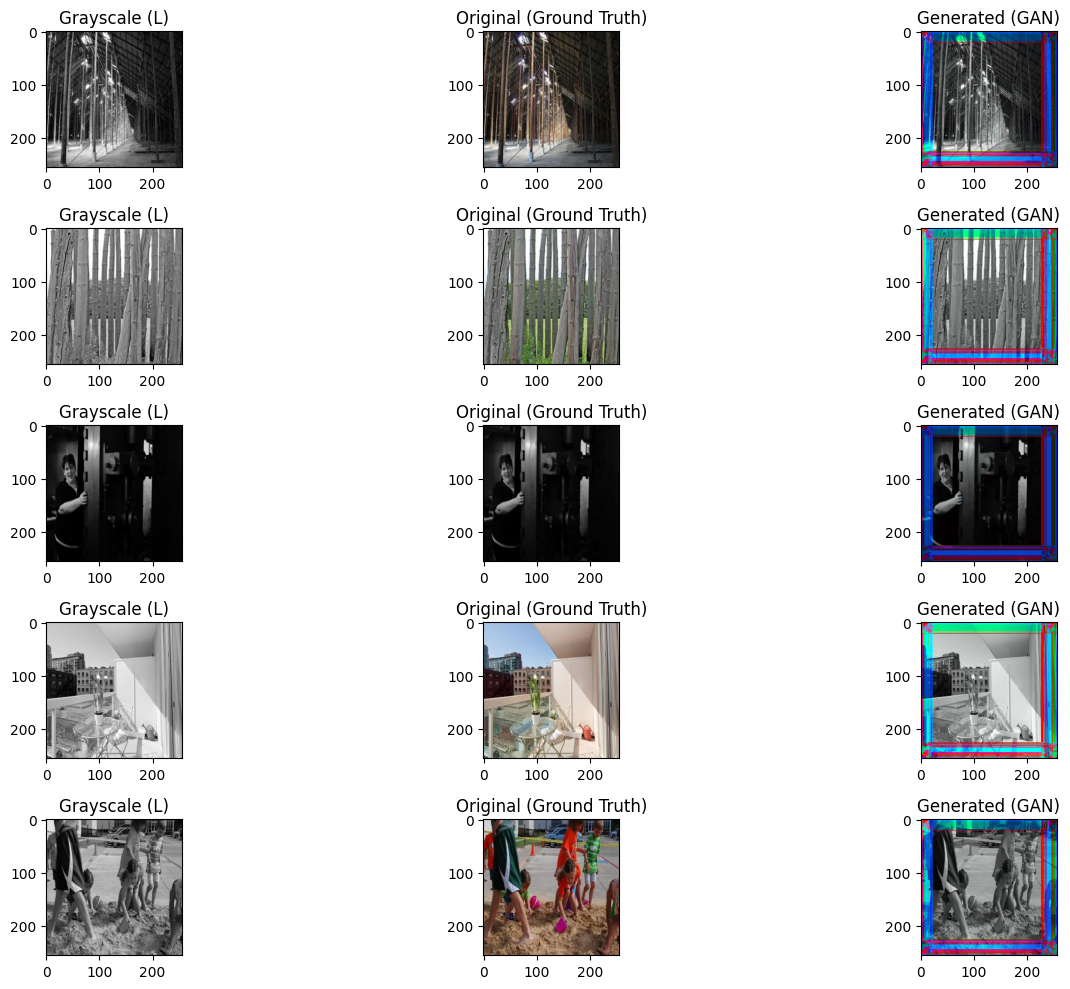

In [ ]:
from keras.models import load_model
from skimage.color import lab2rgb
import matplotlib.pyplot as plt
import numpy as np

# Load the trained generator model
generator = load_model('generator_model.h5')

# Predict color channels (ab) for testing images
predicted_ab = generator.predict(test_x)

# Denormalize L and ab channels for LAB to RGB conversion
test_L = test_x * 100.0  # L channel denormalized to range [0, 100]
predicted_ab = predicted_ab * 128.0  # ab channels denormalized to range [-128, 128]

# Visualize the results
num_images_to_display = 5  # Number of images to display
plt.figure(figsize=(15, 10))

for i in range(num_images_to_display):
    # Select a test image
    original_L = test_L[i]
    original_ab = test_y[i] * 128.0  # Denormalize ground truth ab channels
    generated_ab = predicted_ab[i]

    # Combine original L with ground truth ab for reference
    original_lab = np.concatenate((original_L, original_ab), axis=-1)
    original_rgb = lab2rgb(original_lab)

    # Combine original L with generated ab for GAN output
    generated_lab = np.concatenate((original_L, generated_ab), axis=-1)
    generated_rgb = lab2rgb(generated_lab)

    # Display the grayscale, ground truth, and GAN-generated images
    plt.subplot(num_images_to_display, 3, i * 3 + 1)
    plt.imshow(original_L[:, :, 0], cmap='gray')
    plt.title("Grayscale (L)")

    plt.subplot(num_images_to_display, 3, i * 3 + 2)
    plt.imshow(original_rgb)
    plt.title("Original (Ground Truth)")

    plt.subplot(num_images_to_display, 3, i * 3 + 3)
    plt.imshow(generated_rgb)
    plt.title("Generated (GAN)")

plt.tight_layout()
plt.show()
